## Decision Tree

En este archivo se hace una prueba de calsificador usando Decision Tree.

De manera independiente se van a cargar las librerías necesarias para el script. A la hora de realizar este script, dado que vamos a usar el arbol de decisiones, solo es necesrio usar Sklearn, Matplotlib para graficar al final, numpy para el procesamiento de los datos y os para moverse entre carpetas.

In [1]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns

Como en el resto de códigos, en este la carga de datos se hace de manera similar a las otras. Se cargan los datos desde "load_signal" y se preprocesan los datos y se extraen las características principales desde "preprocess_signal".

In [2]:
def preprocess_signal(signal):

    # Parámetros teóricos
    max_theoretical_value = 230 * np.sqrt(2)

    # Media de la señal
    mean_value = np.mean(signal)

    # Datos sin sesgo
    unbias_data = signal - mean_value
    unbias_data_2 = unbias_data ** 2
    unbias_data_3 = unbias_data_2 * unbias_data
    unbias_data_4 = unbias_data_3 * unbias_data

    # Cálculo de características
    variance = np.var(unbias_data)  # Varianza
    skewness = np.mean(unbias_data_3) / (variance ** 1.5)  # Asimetría
    kurtosis = np.mean(unbias_data_4) / (variance ** 2) - 3  # Curtosis
    thd = np.sqrt(np.sum(np.abs(np.fft.fft(signal)[2:4])) / np.abs(np.fft.fft(signal)[1]))  # Distorsión armónica total
    rms = np.sqrt(np.mean(signal ** 2))  # Valor RMS
    crest_factor = np.max(signal) / rms  # Factor de cresta

    # Devuelve todas las características en un vector
    return np.array([variance, skewness, kurtosis, thd, crest_factor])

def load_signal(data_path):

    # Asignar etiquetas explícitamente
    label_mapping = {
        "flicker_signals": 0,
        "harmonic_signals": 1,
        "interruption_signals": 2,
        "original_signals": 3,
        "sag_signals": 4,
        "swell_signals": 5,
        "transient_signals": 6,
        "harmonic_sag_signals": 7,
        "harmonic_swell_signals": 8,
        "Harmonic_interruption_signals": 9,
    }

    # Inicialización de listas para características y etiquetas
    features = []
    labels = []

    # Iterar por cada tipo de perturbación.
    for signal_type, label in label_mapping.items():
        signal_type_path = os.path.join(data_path, signal_type)

        if os.path.isdir(signal_type_path):
            for subset in ["train", "test", "val"]:
                subset_path = os.path.join(signal_type_path, subset)

                if os.path.exists(subset_path):
                    for filename in os.listdir(subset_path):
                        if filename.endswith(".npy"):
                            file_path = os.path.join(subset_path, filename)

                            # Cargar la señal
                            signal = np.load(file_path)

                            # Procesar la señal y extraer características
                            feature_vector = preprocess_signal(signal)

                            # Agregar las características y etiquetas a las listas
                            features.append(feature_vector)
                            labels.append(label)

    return np.array(features), np.array(labels)

# Ejemplo de uso
data_path = "data"  # Ajusta esta ruta según sea necesario
features, labels = load_signal(data_path)

print(f"Características extraídas: {features.shape}")
print(f"Etiquetas extraídas: {labels.shape}")


# Contar las etiquetas únicas en los datos originales 
unique_labels, counts = np.unique(labels, return_counts=True)
print("Etiquetas únicas:", unique_labels)
print("Distribución de señales por categoría:")
for label, count in zip(unique_labels, counts):
    print(f"Clase {label}: {count} señales")

# He tenido problemas a la hora de cargar los datos, en ocasiones no cargaba la variable 3 y se creaba la 7.
# Es una flag.
if 3 not in unique_labels: 
    print("Error: La clase 3 no está presente en los datos originales.")

Características extraídas: (108000, 5)
Etiquetas extraídas: (108000,)
Etiquetas únicas: [0 1 2 3 4 5 6 7 8 9]
Distribución de señales por categoría:
Clase 0: 10800 señales
Clase 1: 10800 señales
Clase 2: 10800 señales
Clase 3: 10800 señales
Clase 4: 10800 señales
Clase 5: 10800 señales
Clase 6: 10800 señales
Clase 7: 10800 señales
Clase 8: 10800 señales
Clase 9: 10800 señales


Un arbol de decisión es un modelo de clasificación que divide los datos en función de unas reglas basadas en características, formando una estructura interpretable.

Se ha deividido los datos en 80% de entrenamiento y 20% de test. La precisión se muestra mediante "accuracy" y el reporte de clasificación con los valores de precisión y f1-score de cada clase.

En la primera línea tenemos la básica para cargar los datos, donde repartimos los datos de entrenamiento y test.

train_test_splits:
1. features porque son las entradas que se dan iniciales a partir de los datos.
2. labels son las salidas, que lo convierte en un sistema multiclase (7 en este momento)
3. stratify=labels, hace que el reparto de clases sea proporcional si los conjunto de datos están desbalanceados, en este caso en cada clase tenemos 10800 muestras y no sería estrictamente necesario ponerlo, pero lo pongo para que no se me olvide cuando haga el cruce con datos externos que estén desbalanceados.
4. test_size=0.2, 80% train, 20% test
5. random_state=1, simplemente se le da un número para que cada vez que itere con distintos hiperparámetros, los datos sean los mismos.

En el futuro, cuando se quiera cruzar datos con datos externos que no sean los del experimento habrá que evitar el train_test_splits.

1. X_train serán los datos actuales, en este caso será el vector de características "feature" que se extraen directamente del subprograma anterior.
2. X_test serán los datos cruzados, será el vector de caracteristicas "feature_2" que se extraerán de otro subprograma.
3. y_train es el vector de clases, deberá coincidir con el numero tipos de datos que hay en el modelo.
4. y_pred será la predicción.

En este modelo en concreto se ha modificado para que no busque el modelo standars, sino que busque entre diferentes hiperparámetros la mejor opción, de ahí las funciones de "GridSearchCV"

In [3]:
# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=1, stratify=labels)

# Definir los hiperparámetros a buscar
param_grid = {
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'criterion': ['gini', 'entropy']
}

# Crear el modelo base, este es sin buscador, se puede usar, pero la función de arriba "param_grid" se puede omitir.
dt_model = DecisionTreeClassifier(random_state=42)
#dt_model.fit(X_train, y_train)

#Aquí haplicamos el buscador de parámetros.
grid_search = GridSearchCV(estimator=dt_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_


# Imprimir los mejores parámetros y la mejor puntuación
print(f"Mejores hiperparámetros: {grid_search.best_params_}")

# Entrenar un nuevo modelo con los mejores parámetros
best_dt_model = grid_search.best_estimator_
#y_pred = dt_model.predict(X_test)
best_dt_reg = grid_search.best_estimator_ # Get the best estimator from the grid search
y_pred = best_dt_reg.predict(X_test)


# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy del modelo de Árbol de Decisión: {accuracy:.2f}")

print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Mejores hiperparámetros: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Accuracy del modelo de Árbol de Decisión: 0.96

Reporte de clasificación:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2160
           1       0.95      0.95      0.95      2160
           2       0.96      0.97      0.97      2160
           3       1.00      1.00      1.00      2160
           4       0.93      0.93      0.93      2160
           5       0.91      0.91      0.91      2160
           6       1.00      1.00      1.00      2160
           7       0.95      0.94      0.94      2160
           8       0.92      0.92      0.92      2160
           9       1.00      1.00      1.00      2160

    accuracy                           0.96     21600
   macro avg       0.96      0.96      0.96     21600
weighted avg       0.96      0.96      0.96 

Además de obtener una predicción, y ver como se comporta el modelo, a través de la librería "seaborn" podemos graficar el la matriz de confusión que nos diga donde hay confusión en los datos a la hora de clasificarse.

Recordando la clasificación de las clases:

1. Flicker
2. Harmónico
3. Interrupción
4. Señal Original
5. Sag
6. Swell
7. Transitorios
8. Harmonico+Sag
9. Harmonico+Swell
10. Harmonico+Interruption

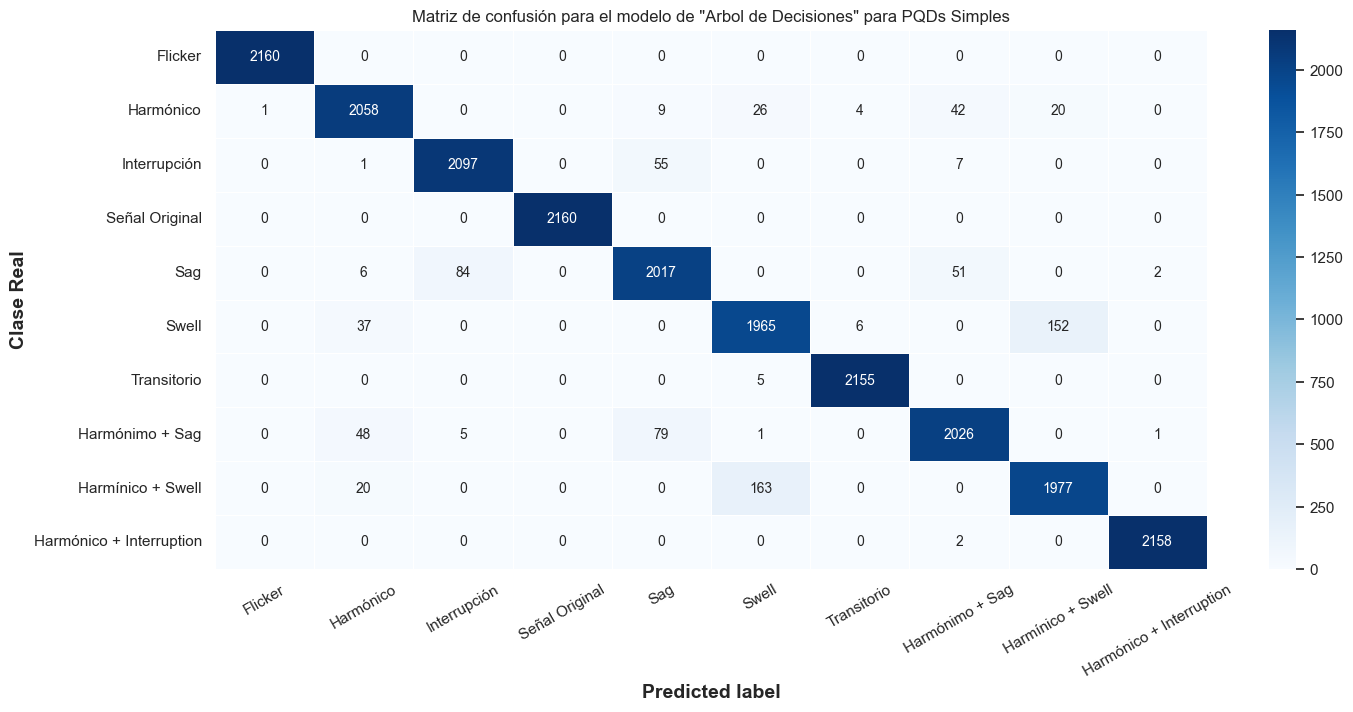

In [4]:
# Se tiene que haber cargado "confusion_matrix" desde scikit_Learn
matrix = confusion_matrix(y_test, y_pred)

# La mejor dimensión que he encontrado para que se muestre es 16x7, menor se solapan los nombres
plt.figure(figsize=(16,7))
# Simplemente dejar la escala de la fuente en un número que no sea demasiado grande
sns.set(font_scale=1)
# importante fmt = 'd', si no, lo valores se mostrarán porcentualmente. cmap Blues porque me gusta el azul.
sns.heatmap(matrix, annot=True, annot_kws={'size':10},fmt= 'd' ,cmap=plt.cm.Blues, linewidths=0.5)

# Add labels to the plot
class_names = ['Flicker', 'Harmónico', 'Interrupción', 'Señal Original', 'Sag', 'Swell','Transitorio',"Harmónimo + Sag","Harmínico + Swell", "Harmónico + Interruption"]
tick_marks = np.arange(len(class_names)) + 0.5
tick_marks2 = tick_marks
plt.xticks(tick_marks, class_names, rotation=30)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label', weight='bold', fontsize=14)
plt.ylabel('Clase Real', weight='bold', fontsize=14)
plt.title('Matriz de confusión para el modelo de "Arbol de Decisiones" para PQDs Simples')
plt.show()
